# Прогнозирование температуры звезды

![The color of Stars](https://sciencenotes.org/wp-content/uploads/2022/04/The-Colors-of-Stars-From-Hottest-to-Coldest.png)

Источник [sciencenotes.org](https://sciencenotes.org/the-colors-of-the-stars-from-hottest-to-coldest/)

## Введение

Цветовая классификация звезд https://sciencenotes.org/the-colors-of-the-stars-from-hottest-to-coldest/

Закзачик — обсерватория «Небо на ладони» — хочет перейти на технологии машинного обучения для определения температуры поверхности звезд. 

Для поиска решения на основе нейронных сетей заказчик предоставил харасктеристики и значения температуры 240 звезд. Характеристики данных следующие:
1. Относительная светимость $L/L_o$ — светимость звезды относительно Солнца.
1. Относительный радиус $R/R_o$ — радиус звезды относительно радиуса Солнца.
1. Абсолютная звёздная величина $M_v$ — физическая величина, характеризующая блеск звезды.
1. Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
1. Тип звезды:
    - 0 — Коричневый карлик
    - 1 — Красный карлик
    - 2 — Белый карлик
    - 3 — Звёзды главной последовательности
    - 4 — Сверхгигант
    - 5 — Гипергигант
1. Абсолютная температура $T(K)$ — температура на поверхности звезды в Кельвинах. 

Заказчик ожидает, что разработанная модель будет иметь RMSE не более 4500.

Заказчик просит включит в отчет график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

### Цель проекта

Целью проекта является разработка архитектуры и обучение модели, предсказывающей температуру поверхности звезды. 

Качество модели оценивается метрикой среднеквадратичная ошибка (RMSE) и должно быть меньше или равно 4500.

### Основные этапы

В проекты выполнены следующие основные этапы:
- исследовательский анализ данных,
- разработка базовой модели,
- улучшение модели.

### Выводы

Мы разработали модель, позволяющую определять температуру звезды по 5 характеристикам. Среднквадратичная ошибка предсказания на тестовых данных 2000.



## Подготовка кода

### Загрузка библиотек

In [1]:
from os import path
from functools import partial
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

In [4]:
import torch
import torch.nn as nn

In [5]:
RANDOM_STATE = 2575215

### Функции и классы

#### normalize_color_values

In [6]:
def normalize_color_values(color: str) -> str:
    """Приводит значение цвета к форме: нижний регистр через пробел без"""
    
    return " ".join([_.strip() for _ in color.lower().replace("-", " ").split()])

#### reduce_color_values

In [7]:
def reduce_color_values(reduction_dict: dict, color: str) -> str:
    """Заменяет значение цвета на значение из словаря, либо возвращает исходное значение"""
    
    return reduction_dict[color] if color in reduction_dict else color

#### calc_vif

Основано на решении [steven](https://stackoverflow.com/a/54857466) @ stackoverflow, рассчитывает фактор инфляции дисперсии $ \mathit{VIF} = \frac{1}{1 - R^2}$ и толерантность $T = 1 - R$

In [8]:
def calc_vif(exogs: list, data: pd.DataFrame) -> pd.DataFrame:
    """Рассчитывает фактор инфляции дисперсии и толерантность для признаков exogs"""

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

## Загрузка данных

In [9]:
remote_path = 'https://code.s3.yandex.net/datasets/6_class.csv'
local_path = path.join('.', 'data', '6_class.csv')

if path.isfile(local_path):
    data = pd.read_csv(local_path, index_col=0)
else:
    data = pd.read_csv(remote_path, index_col=0)
    if path.exists(path.dirname(local_path)):
        data.to_csv(local_path)
        
data.shape

(240, 6)

Загружено 240 строк данных и 6 признаков.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [11]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


Состав признаков и их значения соответствуют информации в задаче. 

Приведем названия признаков к snake-case.

In [12]:
data.columns = [
    'temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type',
    'star_color'
]

### Разделение данных

Будем придреживаться принципа, согласно которому мы не должны видеть тестовые данные до этапа тестирования моделей. Поэтому выделим данные для теста до исследовательского анализа. Для теста оставим 10% даных.

In [13]:
X = data.drop('temperature', axis=1)
y = data.temperature
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.15,
                                                    random_state=RANDOM_STATE)

In [14]:
X_train.shape, y_train.shape

((204, 5), (204,))

In [15]:
X_test.shape, y_test.shape

((36, 5), (36,))

Размер выборок корректный.

Сравним статистики целевого признака для обучающей и тестовой выборок.

In [16]:
y_train.describe()

count      204.000000
mean     10504.230392
std       9581.423090
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15554.500000
max      40000.000000
Name: temperature, dtype: float64

In [17]:
y_test.describe()

count       36.000000
mean     10459.111111
std       9520.297072
min       2731.000000
25%       3353.750000
50%       5981.000000
75%      14106.250000
max      38234.000000
Name: temperature, dtype: float64

Статистики целевого признака на обучающей и тестовой выборке похожи. Разделение данных выполнено корректно.

### Вывод

Мы загрузили полученные данные. Состав признаков и количество объектов соответствуют указанным в задаче. 

Из данных мы выделили 15% объектов для тестирования результатов. 

Исследовательский анализ, обучение и настройку моделей будем проводить на обучающей выборки, из которой выделим валидационную.

## Исследовательский анализ данных

Сделаем датасет для анализа на основе обучающей выборки.

In [18]:
df = X_train.join(y_train).copy()

### Структура данных

В нашем датасете 240 объектов, 5 призаков и один целевой признак.

#### Типы данных признаков

In [19]:
df.dtypes

luminosity            float64
radius                float64
absolute_magnitude    float64
star_type               int64
star_color             object
temperature             int64
dtype: object

Целевой признак целочисленный, 3 признака имеют вещественный тип, один — целый и один — строковый. Целым и строковым типами представлены категориальные признаки.

Выделим названия целевого, численных и категориальных признаков.

In [20]:
target_column = ["temperature"]
numerical_columns = ["luminosity", "radius", "absolute_magnitude"]
categorical_columns = ["star_type", "star_color"]

#### Количество уникальных значений

In [21]:
df.nunique()

luminosity            180
radius                188
absolute_magnitude    194
star_type               6
star_color             18
temperature           194
dtype: int64

Все числовые признаки имеют сотни значений, то есть являются непрерывными.

#### Статистики числовых признаков

In [22]:
df[numerical_columns + target_column].describe()

,luminosity,radius,absolute_magnitude,temperature
count,204.000000,204.000000,204.000000,204.000000
mean,101994.531578,198.838847,4.707059,10504.230392
std,176958.624939,472.874682,10.408561,9581.423090
min,0.000080,0.008400,-11.920000,1939.000000
25%,0.000817,0.099525,-6.092500,3344.250000
50%,0.021500,0.590000,10.410000,5776.000000
75%,189750.000000,35.250000,13.697500,15554.500000
max,849420.000000,1948.500000,20.060000,40000.000000


Минимальное значение `luminosity` 0.00008, максимальное — 849420. Разница в 11 порядков. Медиана 0.02, среднее — 101994. 

У остальных признаков также видим большую разницу между максимумом и минимумом и смещение медианы от среднего. 

В нашем датасете очень разные звезды, как и во вселенной.

#### Вывод



Мы изучили структуру данных. Убедились, что данные соответсвуют описанным в задаче. 

Мы видим, что звезды в датасете очень сильно отличаются друг от друга по характеристам и распределение значений скошено.

### Качество данных

#### Дубликаты

In [23]:
duplicates_number = df.duplicated().sum()
print(f'Нашли {duplicates_number} дубликатов в датасете.')

Нашли 0 дубликатов в датасете.


#### Пропуски

In [24]:
df.isna().sum()

luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
temperature           0
dtype: int64

Пропусков тоже нет.

#### Паттерны и ошибки заполнения

Проверим наш датасет на проблемы с заполнением числовых значений.

Для каждого числового признака построим график, который визуализирует значения признака (ось Y) для каждого из объектов в датасете (ось X).

Мы ожидаем, что распределение значений будет охватывать весь диапазон по оси Y для всех объектов, то есть на всем протяжении оси X.

Пробелы по оси X покажут ошибки заполнения значений, а визуальные паттерны будут говорить о характере заполнения датасета.

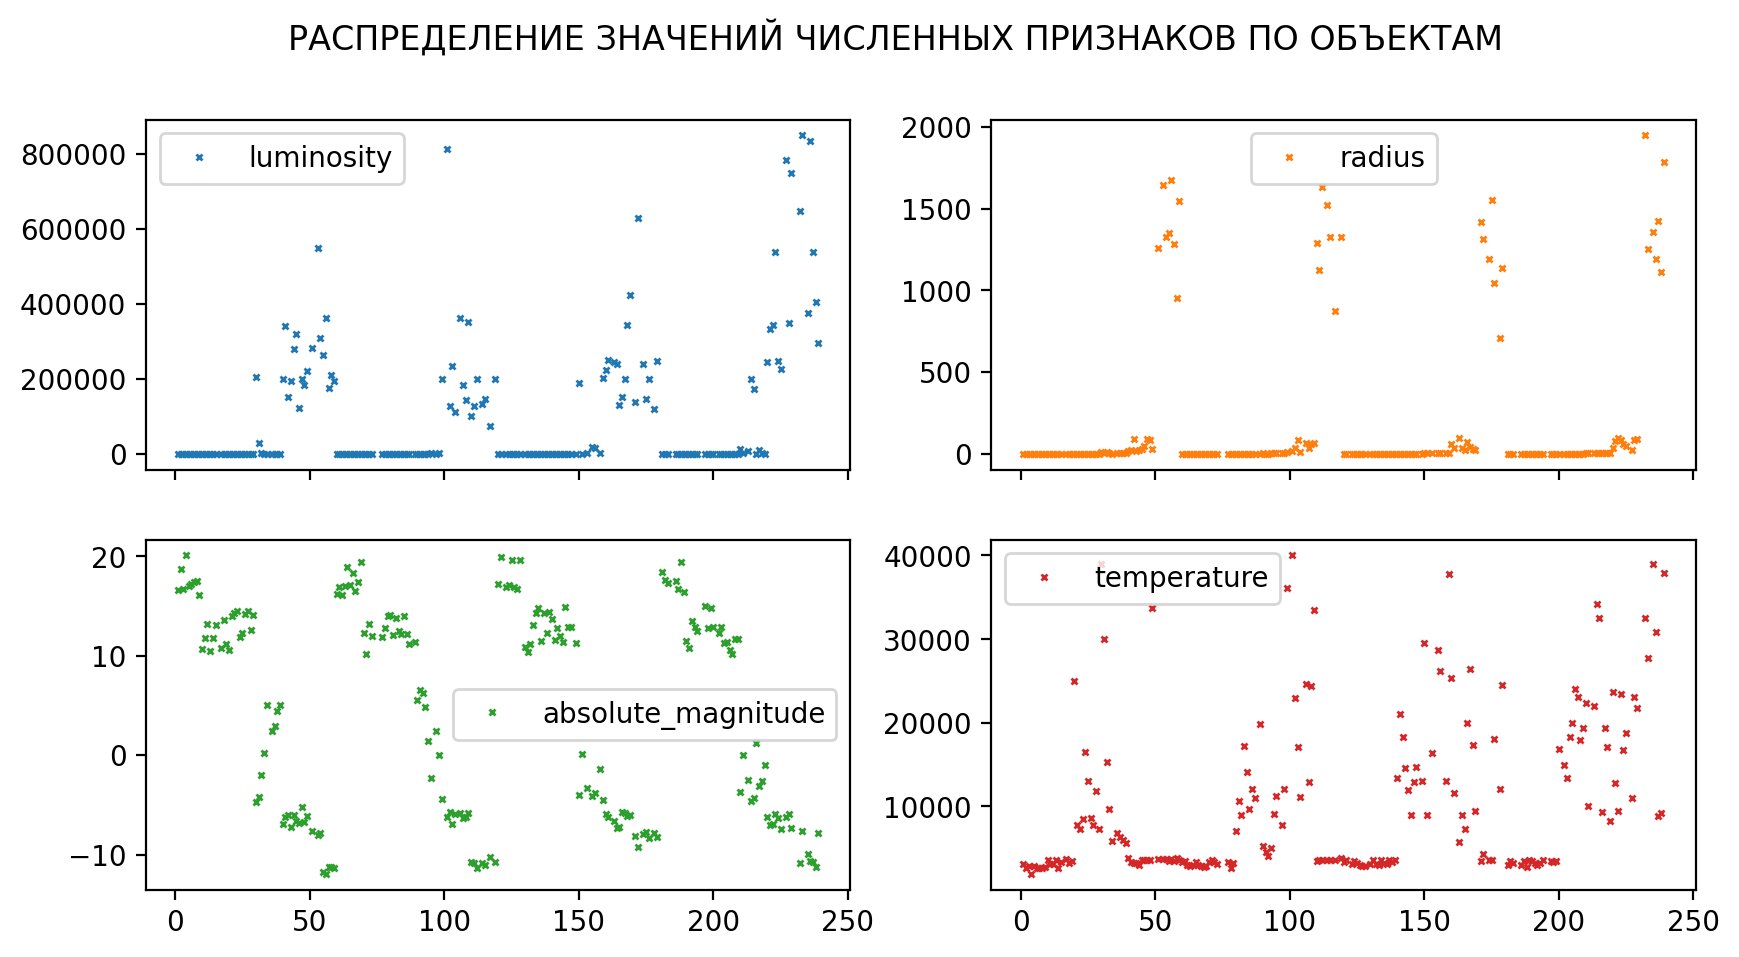

In [25]:
df[numerical_columns+target_column].plot(
    lw=0, marker="x", subplots=True, layout=(-1, 2),
    figsize=(10, 5), markersize=2, 
    title = 'Распределение значений численных признаков по объектам'.upper()
)
plt.legend(loc='upper left')
plt.show()

Мы видим, что датасет собран из 4 порций данных, в каждой из которых наблюдаем убвываение абсолютной зведной величины. 

Значения относительного радиуса группируются в два кластера: около нуля и 1000–2000.


Доля звезд с небольшой отсносительной светимостью и небольшим радиусом в датасете намного больше остальных. Мы наблюдаем дисбаланс данных.

Посмотрим на распределение объектов по категориям.

In [26]:
df.star_type.value_counts()

2    37
4    36
0    34
1    34
3    34
5    29
Name: star_type, dtype: int64

По типам звезд объекты распределены равномерно.

In [27]:
df.star_color.value_counts()

Red                   94
Blue                  48
Blue-white            19
Blue White            10
yellow-white           8
White                  6
Blue white             3
Yellowish White        3
white                  2
Orange                 2
yellowish              2
Yellowish              1
Whitish                1
White-Yellow           1
Blue-White             1
Blue                   1
Pale yellow orange     1
Blue white             1
Name: star_color, dtype: int64

Тут мы видим большое количество дубликтов в названиях категорий. Оъекты распределены неравномерно.

#### Выводы

В данных нет дубликатов и пропусков. 

Значения признаков относительный радиус и относительная светимости имют большой разброс. Мы видим много объектов с маленькими значениями и несколько объектов с очень большими значениями.

В категориальном признаке цвет звезды мы видим неявные дубли в значениях.  

### Содержание данных

#### Анализ значений цвет звезды

Ранее мы видели, что в датасете 18 вариантов цвета звезд. [Современная спетральная классификации звезд](https://ru.wikipedia.org/wiki/Спектральная_классификация_звёзд) (Йеркская классификация или классификация Моргана — Кинана) по цвету имеет 7 классов (цветов)

|#|Класс|Температура (Кельвин, K)|Цвет|Показатель цвета B−V|Абсолютная звёздная величина $M_V$|
|---|---|---|---|---|---|
|1|O|> 30 000|Голубой|−0,3|−5,7…−3,3|
|2|B|10 000—30 000|Бело-голубой|−0,2|−4,1…+1,5|
|3|A|7400—10 000|Белый|0| +0,7…+3,1|
|4|F|6000—7400|Жёлто-белый| +0,4|+2,6…+4,6|
|5|G|5000—6000|Жёлтый| +0,6|+4,4…+6,0|
|6|K|3800—5000|Оранжевый| +1,0|+5,9…+9,0|
|7|M|2500—3800|Красный| +1,5|+9,0…+16|

В наших данных 18 униеальных значений цвета звезд. Изучим эти значения.

In [28]:
df.star_color = df.star_color.apply(normalize_color_values)
df.star_color.value_counts()

red                   94
blue                  49
blue white            34
yellow white           8
white                  8
yellowish white        3
yellowish              3
orange                 2
whitish                1
pale yellow orange     1
white yellow           1
Name: star_color, dtype: int64

Поскольку мы не знаем прицип присвоения значений цвета в нашем датасете, сверим распределение температур и звездных величин с классификацией.

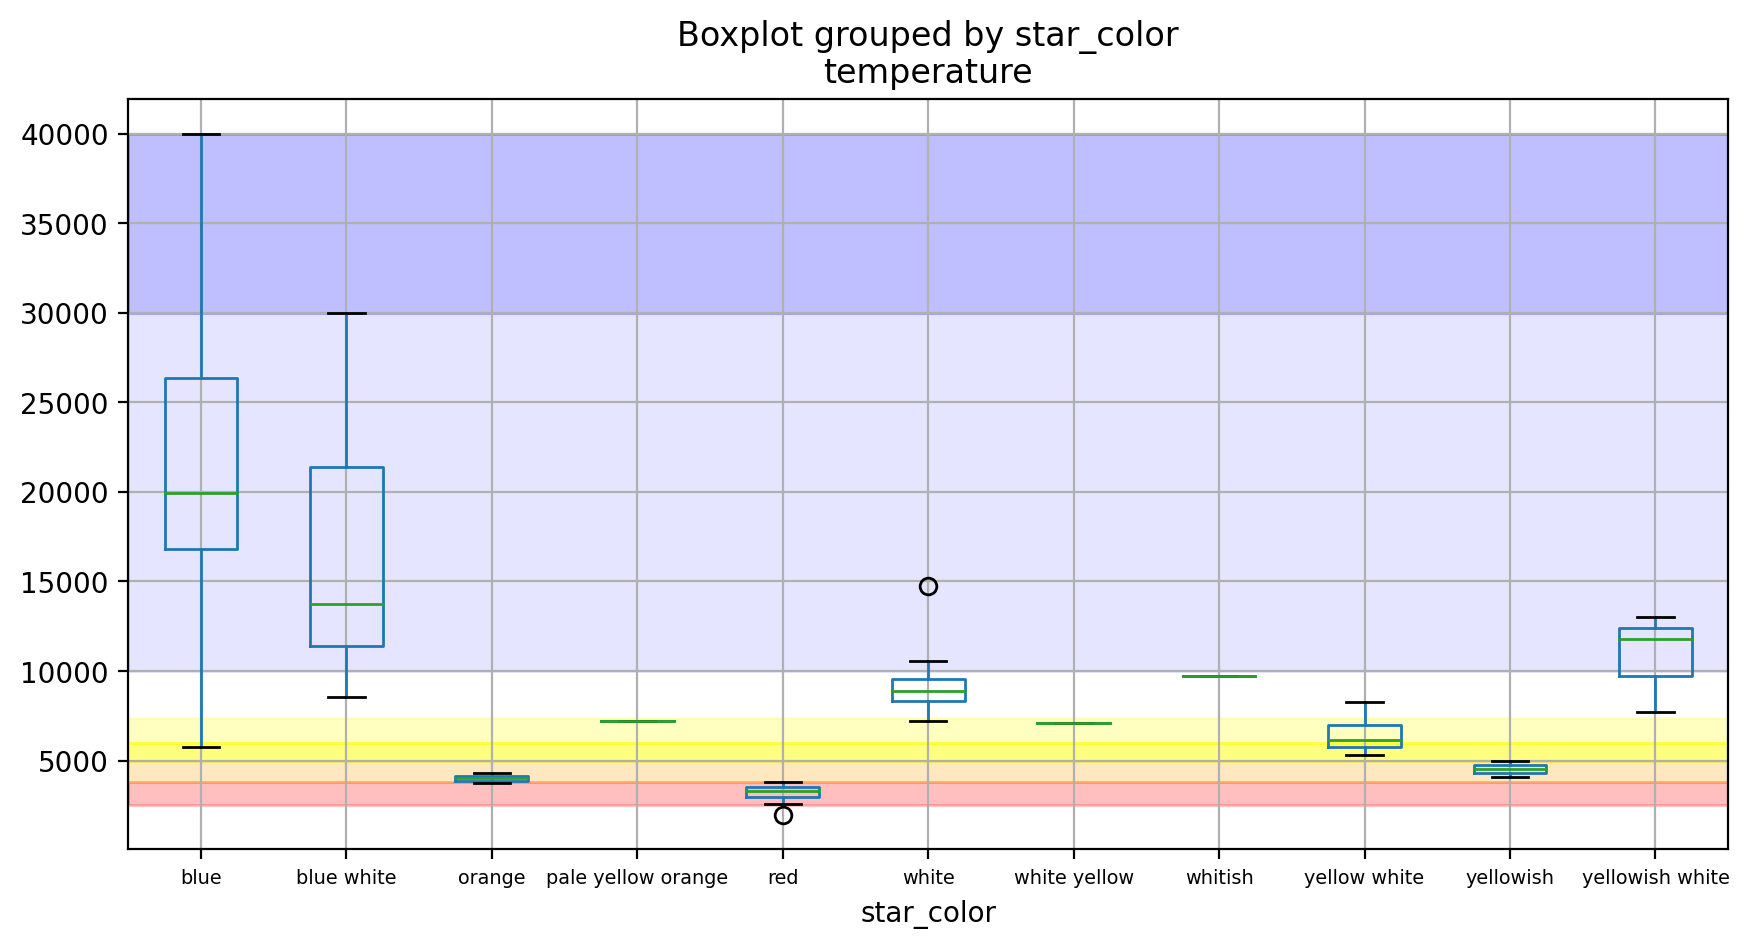

In [29]:
df.boxplot(column=["temperature"], by="star_color", figsize=(10,5))
plt.xticks(fontsize="x-small", rotation=0)
plt.axhspan(2500, 3800, color="red", alpha=.25)
plt.axhspan(3800, 5000, color="orange", alpha=.25)
plt.axhspan(5000, 6000, color="yellow", alpha=.5)
plt.axhspan(6000, 7400, color="yellow", alpha=.25)
plt.axhspan(7400, 10000, color="white", alpha=.1)
plt.axhspan(10000, 30000, color="blue", alpha=.1)
plt.axhspan(30000, 40000, color="blue", alpha=.25)
plt.show()

Мы видим, что некоторые цвета в нашем датасете не соответствуют Йеркской классификации: температура голубых звезд и "yellowish white" в нашем датасете попадает в диапозн темперетар бело-голубых звезд. 

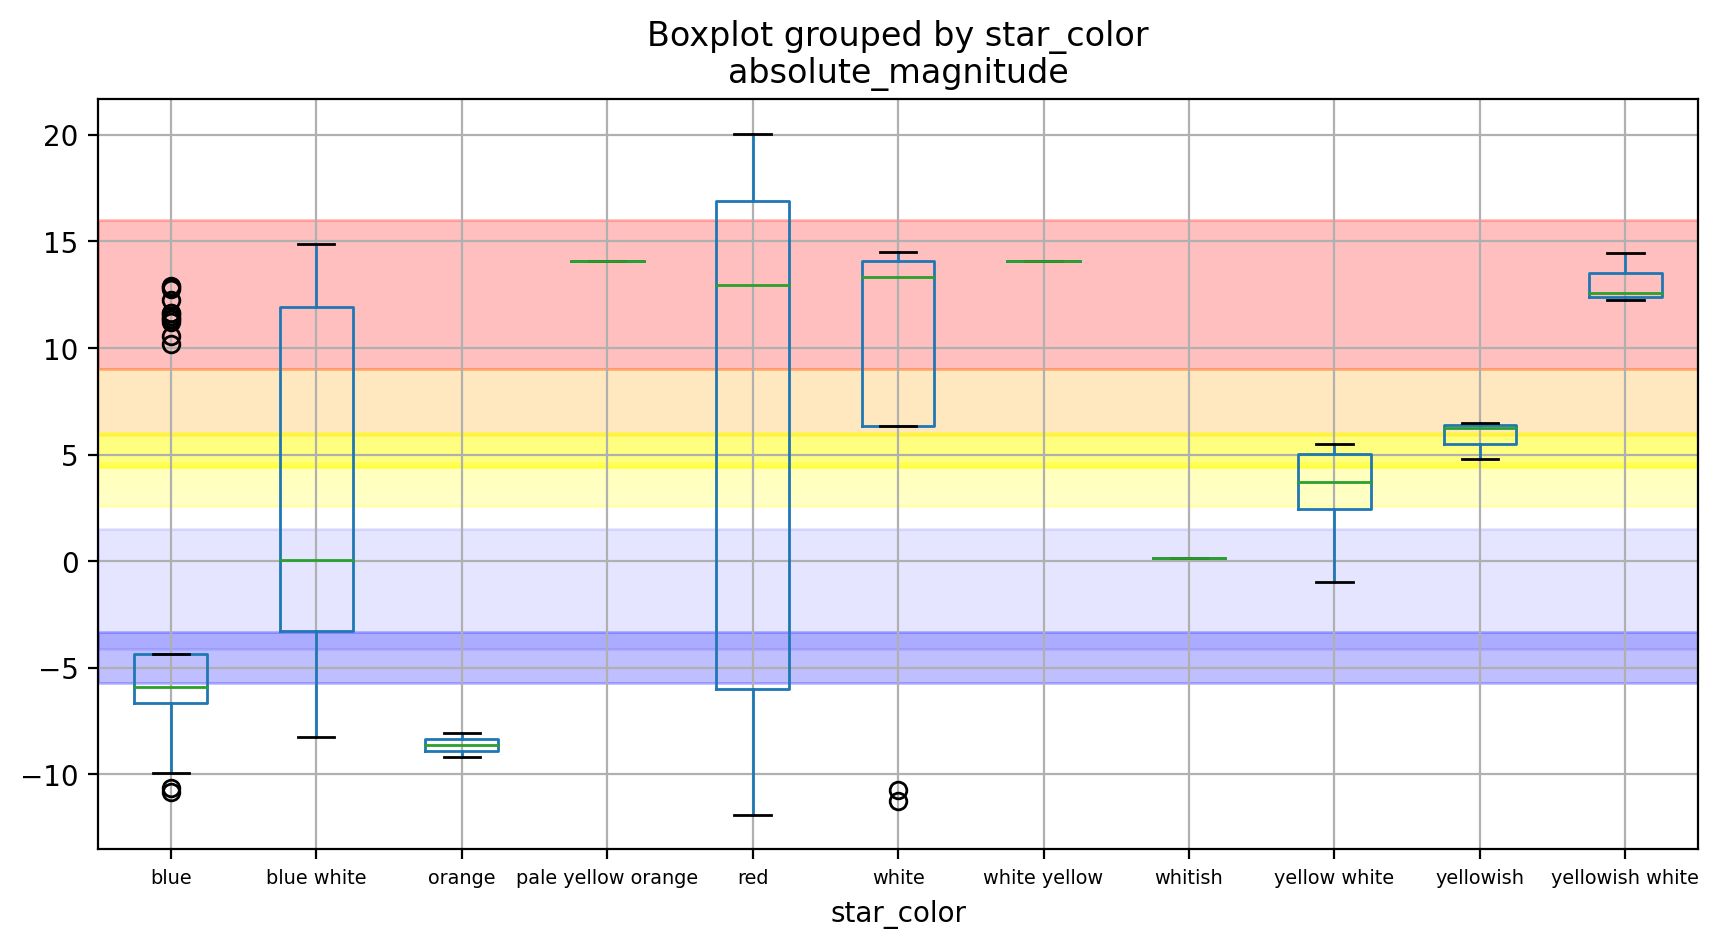

In [30]:
df.boxplot(column=["absolute_magnitude"], by="star_color", figsize=(10,5))
plt.xticks(fontsize="x-small", rotation=0)
plt.axhspan(9, 16, color="red", alpha=.25)
plt.axhspan(5.9, 9, color="orange", alpha=.25)
plt.axhspan(4.4, 6, color="yellow", alpha=.5)
plt.axhspan(2.6, 4.6, color="yellow", alpha=.25)
plt.axhspan(.7, 3.1, color="white", alpha=.1)
plt.axhspan(-4.1, 1.5, color="blue", alpha=.1)
plt.axhspan(-5.7, -3.3, color="blue", alpha=.25)
plt.show()

Тут мы видим, что по абсолютной зведной величине цвета в нашем датасете в большинстве случаев не совпадают с Йерской классификацией.

Значит мы не можем утвежрждать, что цвета отражают современную спекральную классификацию и не можем ориентироваться на нее. 

Сопоставим редкие значения цветов с часто встречающмися, опираясь на сходство по температуре.

In [31]:
reduce_color_values_dict = {
    "yellowish": "orange",
    "yellowish white": "yellow white",
    "pale yellow orange": "yellow white",
    "whitish": "white",
    "white yellow": "yellow white"
}
color_value_reduction_func = partial(reduce_color_values, reduce_color_values_dict)

Оценим количество объектов по значениям цвета после унификации значений.

In [32]:
df.star_color = df.star_color.apply(color_value_reduction_func)
df.star_color.value_counts()

red             94
blue            49
blue white      34
yellow white    13
white            9
orange           5
Name: star_color, dtype: int64

Мы сократили количество цветов до 6 значений. Объекты по-прежнему распределены неравномероно: количество белых и оранжевых звезд на порядок меньше количества красных и голубых.

#### Целевой признак

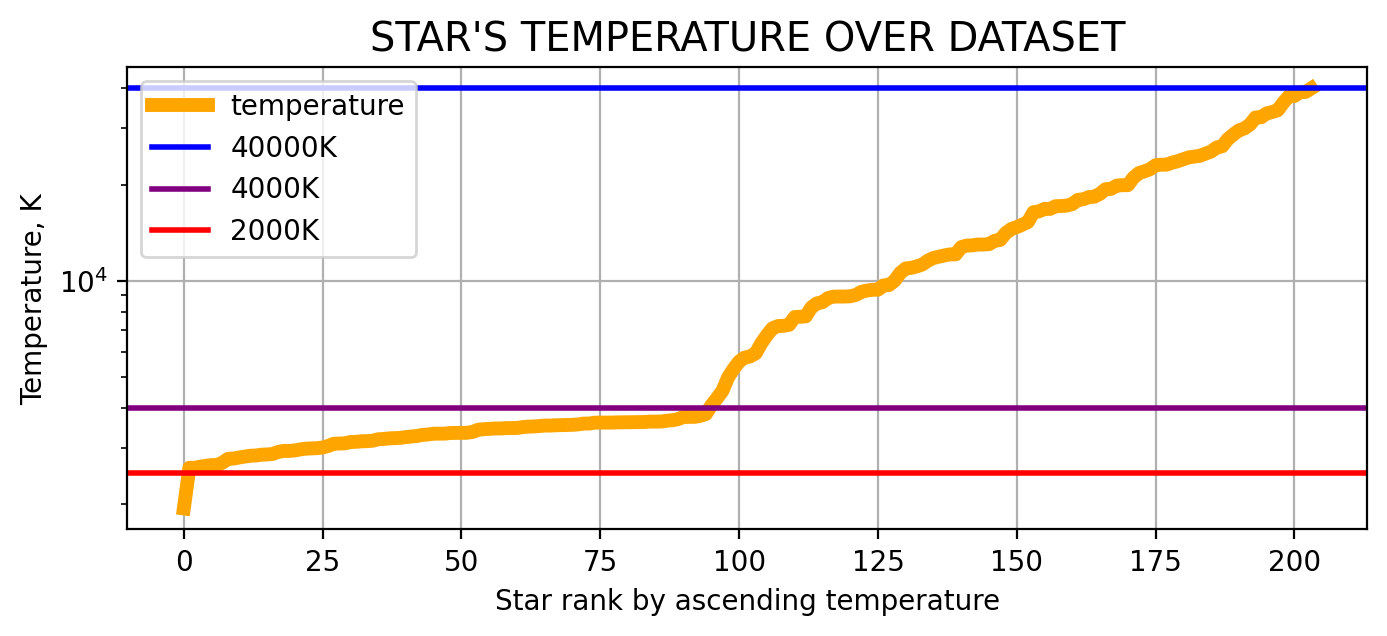

In [101]:
plt.figure(figsize=(8,3))

temperatures = df.temperature.sort_values().reset_index(drop=True)
temperatures.plot(logy=True, grid=True, lw=5,  color="orange", label="temperature")
plt.axhline(40000, color="blue", lw=2, label="40000K")
plt.axhline(4000, color="purple", lw=2, label="4000K")
plt.axhline(2500, color="red", lw=2, label="2000K")
plt.ylabel("Temperature, K")
plt.xlabel("Star rank by ascending temperature")
plt.title("Star's temperature over dataset".upper(), fontsize="x-large")
plt.legend(loc="upper left")
plt.show()

#### Распределение значений

Оценим распределение значений для числовых признаков.

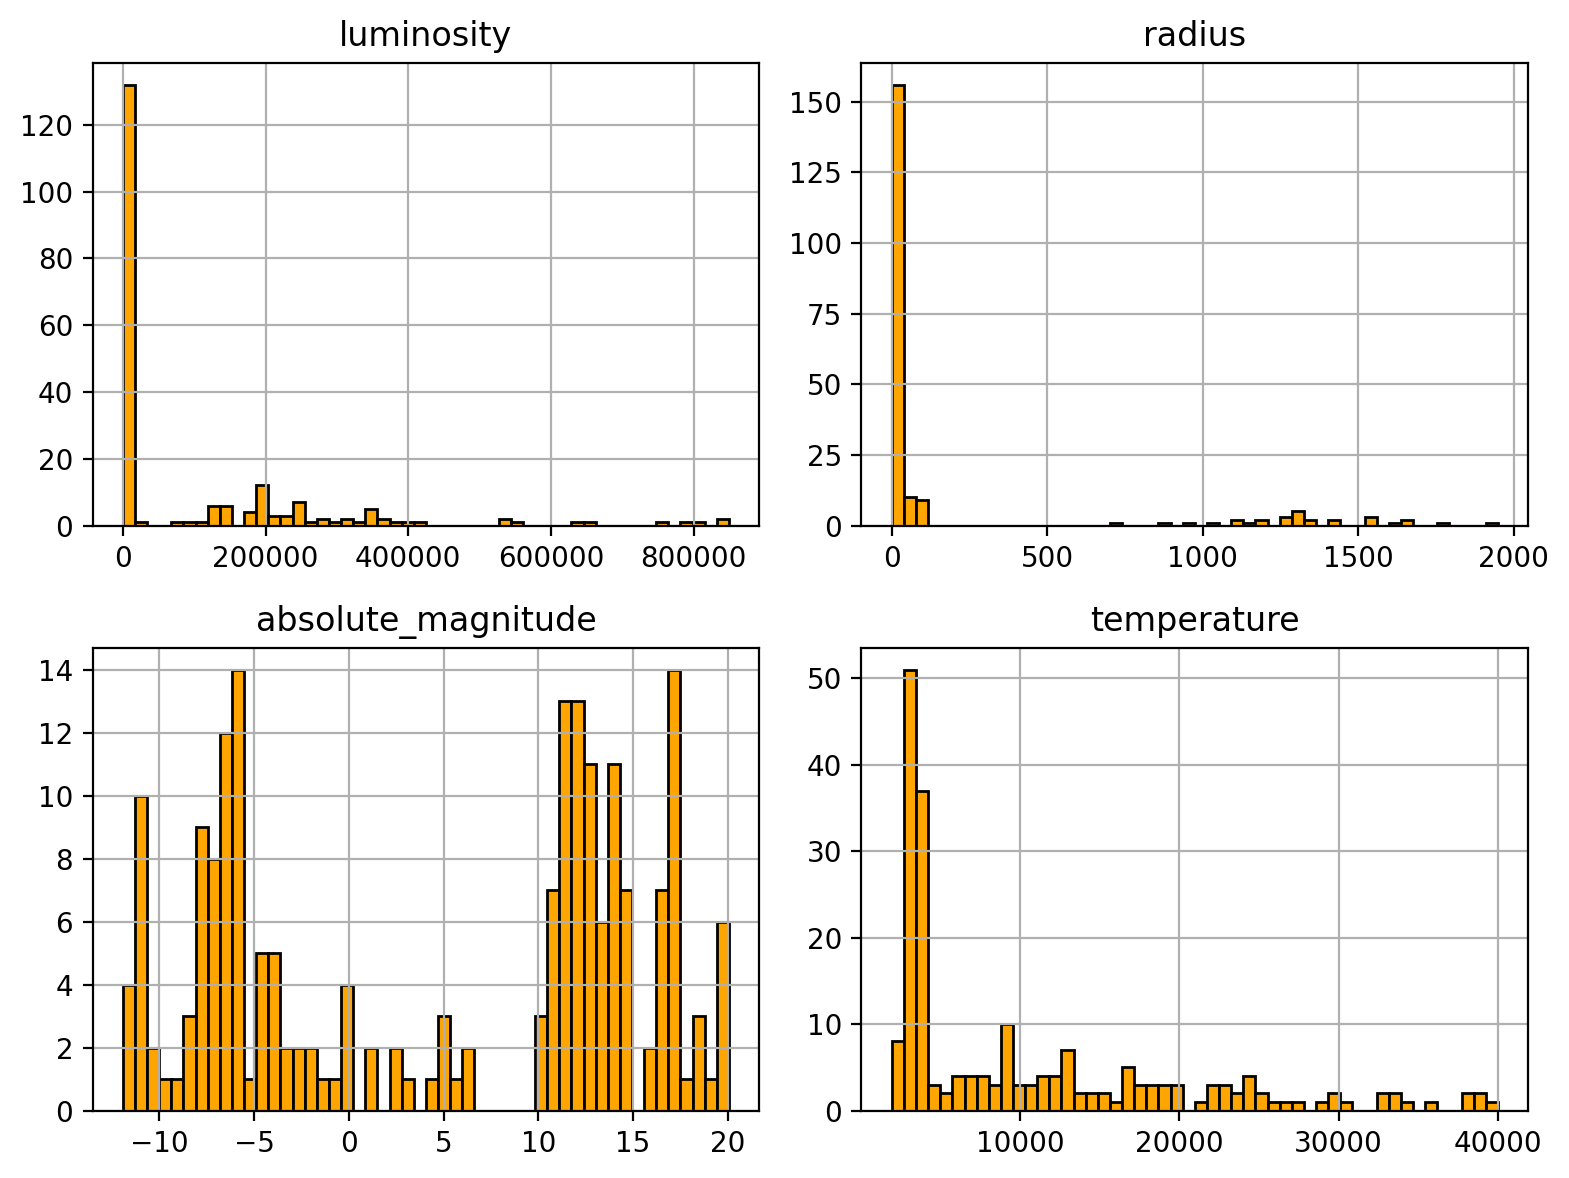

In [33]:
df[numerical_columns + target_column].hist(bins=50,
                                           figsize=(8, 6),
                                           layout=(-1, 2),
                                           color="orange",
                                           edgecolor="black")
plt.tight_layout()
plt.show()

Мы видим, что наш датасет состоит из подмножеств объектов с разными распределениями. Так, у относительных светимости и радиуса мы видим похожее на логнормальное распределение значений в районе нуля, и несколько групп значений с похожим на нормальное распределение: для светимости в раойне 200, 350 и 800 тыс, для радиуса в раоне 1300. 

Мы знаем, что звезды объединяют в классы по схожести признаков, и в наших данных несколько таких классов. Поэтому наблюдаемые распределения соответветсвтуют ожиданиям. 

#### Взаимосвязь признаков

Рассмотрим, как связаны между собой числовые признаки и числовые и категориальные.

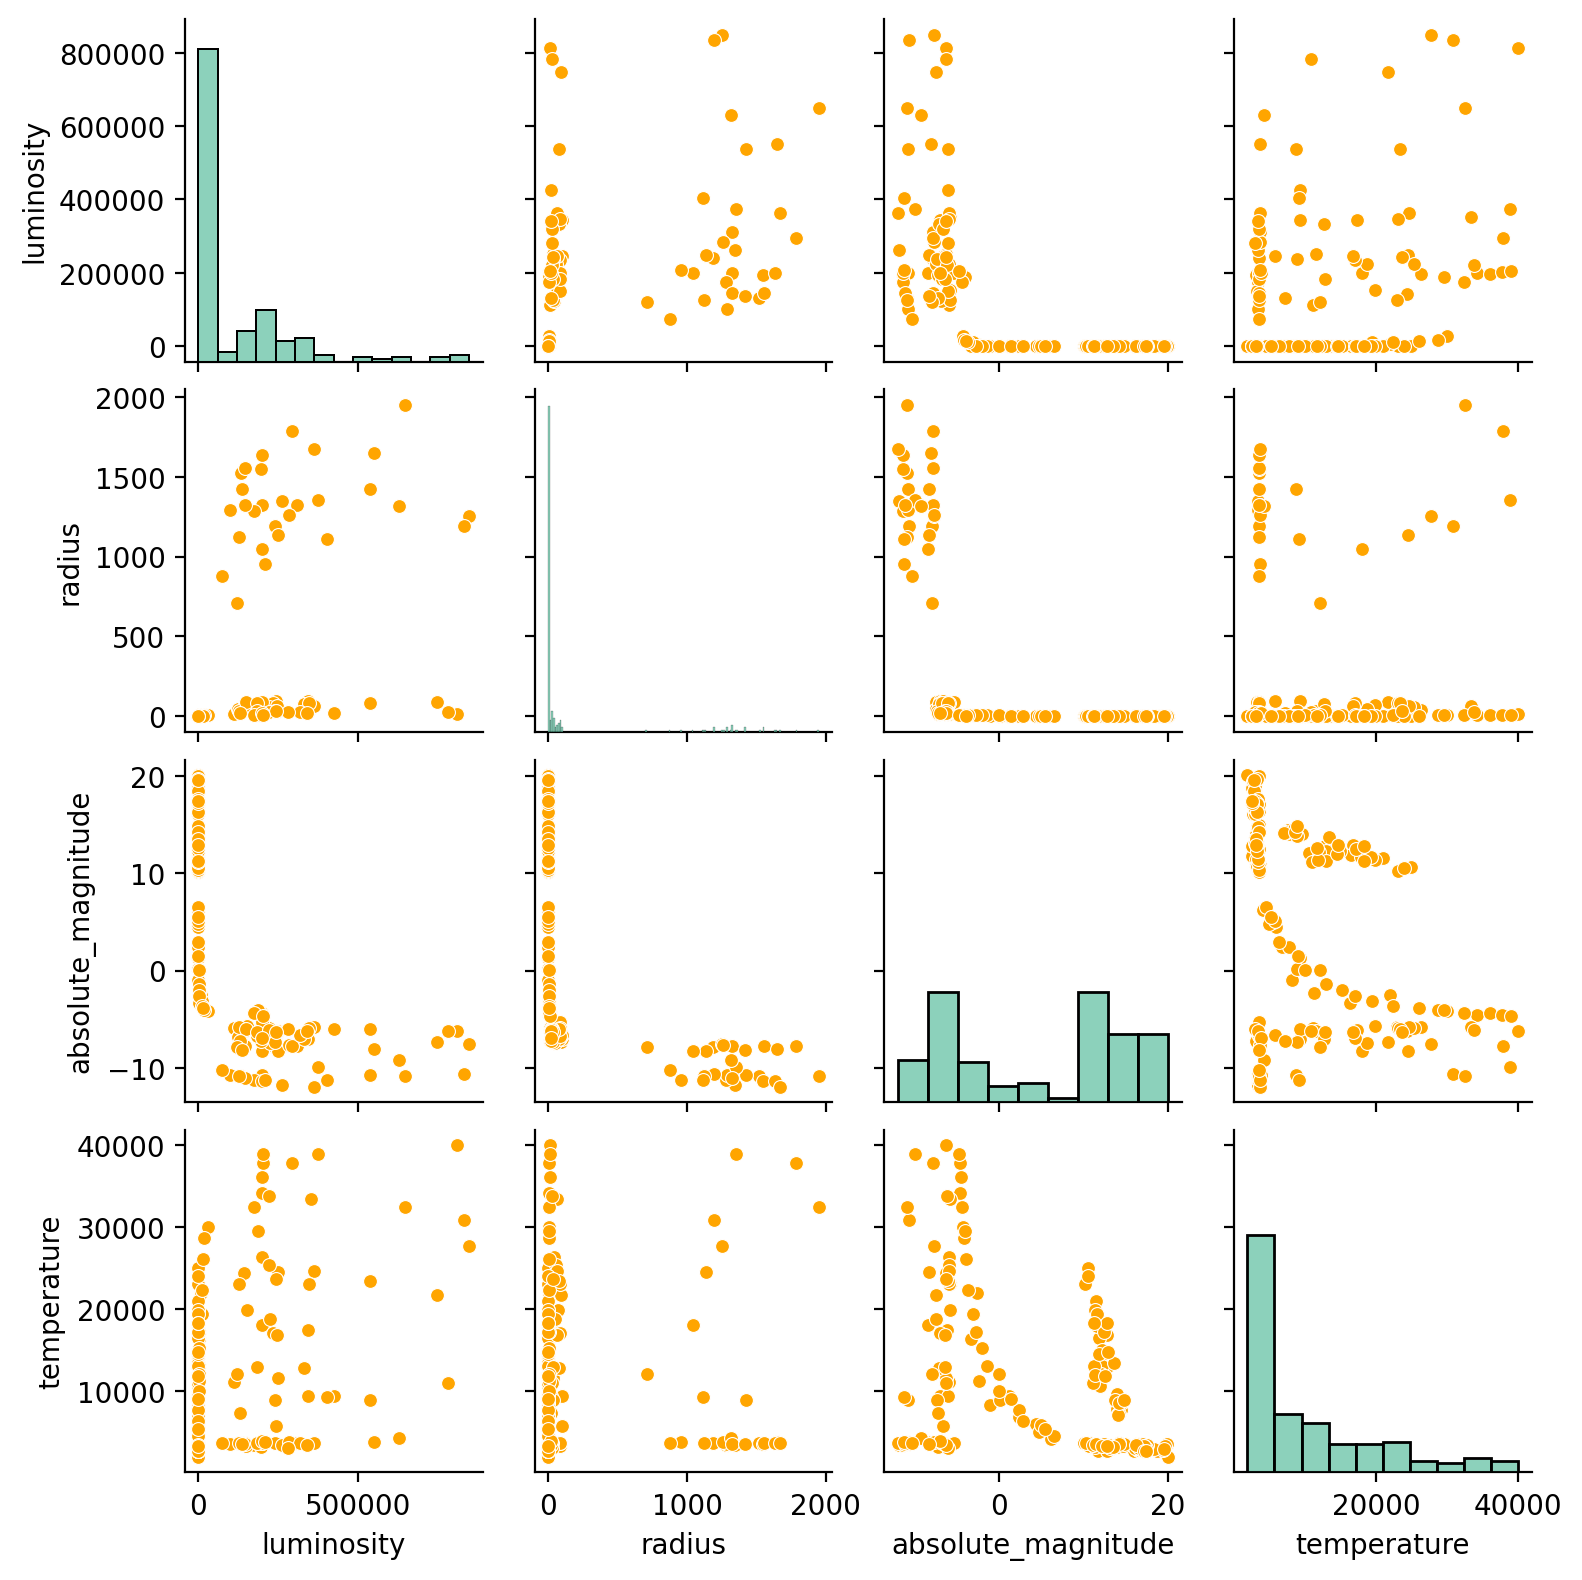

In [34]:
with sns.color_palette("Set2"):
    sns.pairplot(df[numerical_columns + target_column],
                 height=2,
                 plot_kws={
                     "s": 25,
                     "color": "orange"
                 })
plt.show()

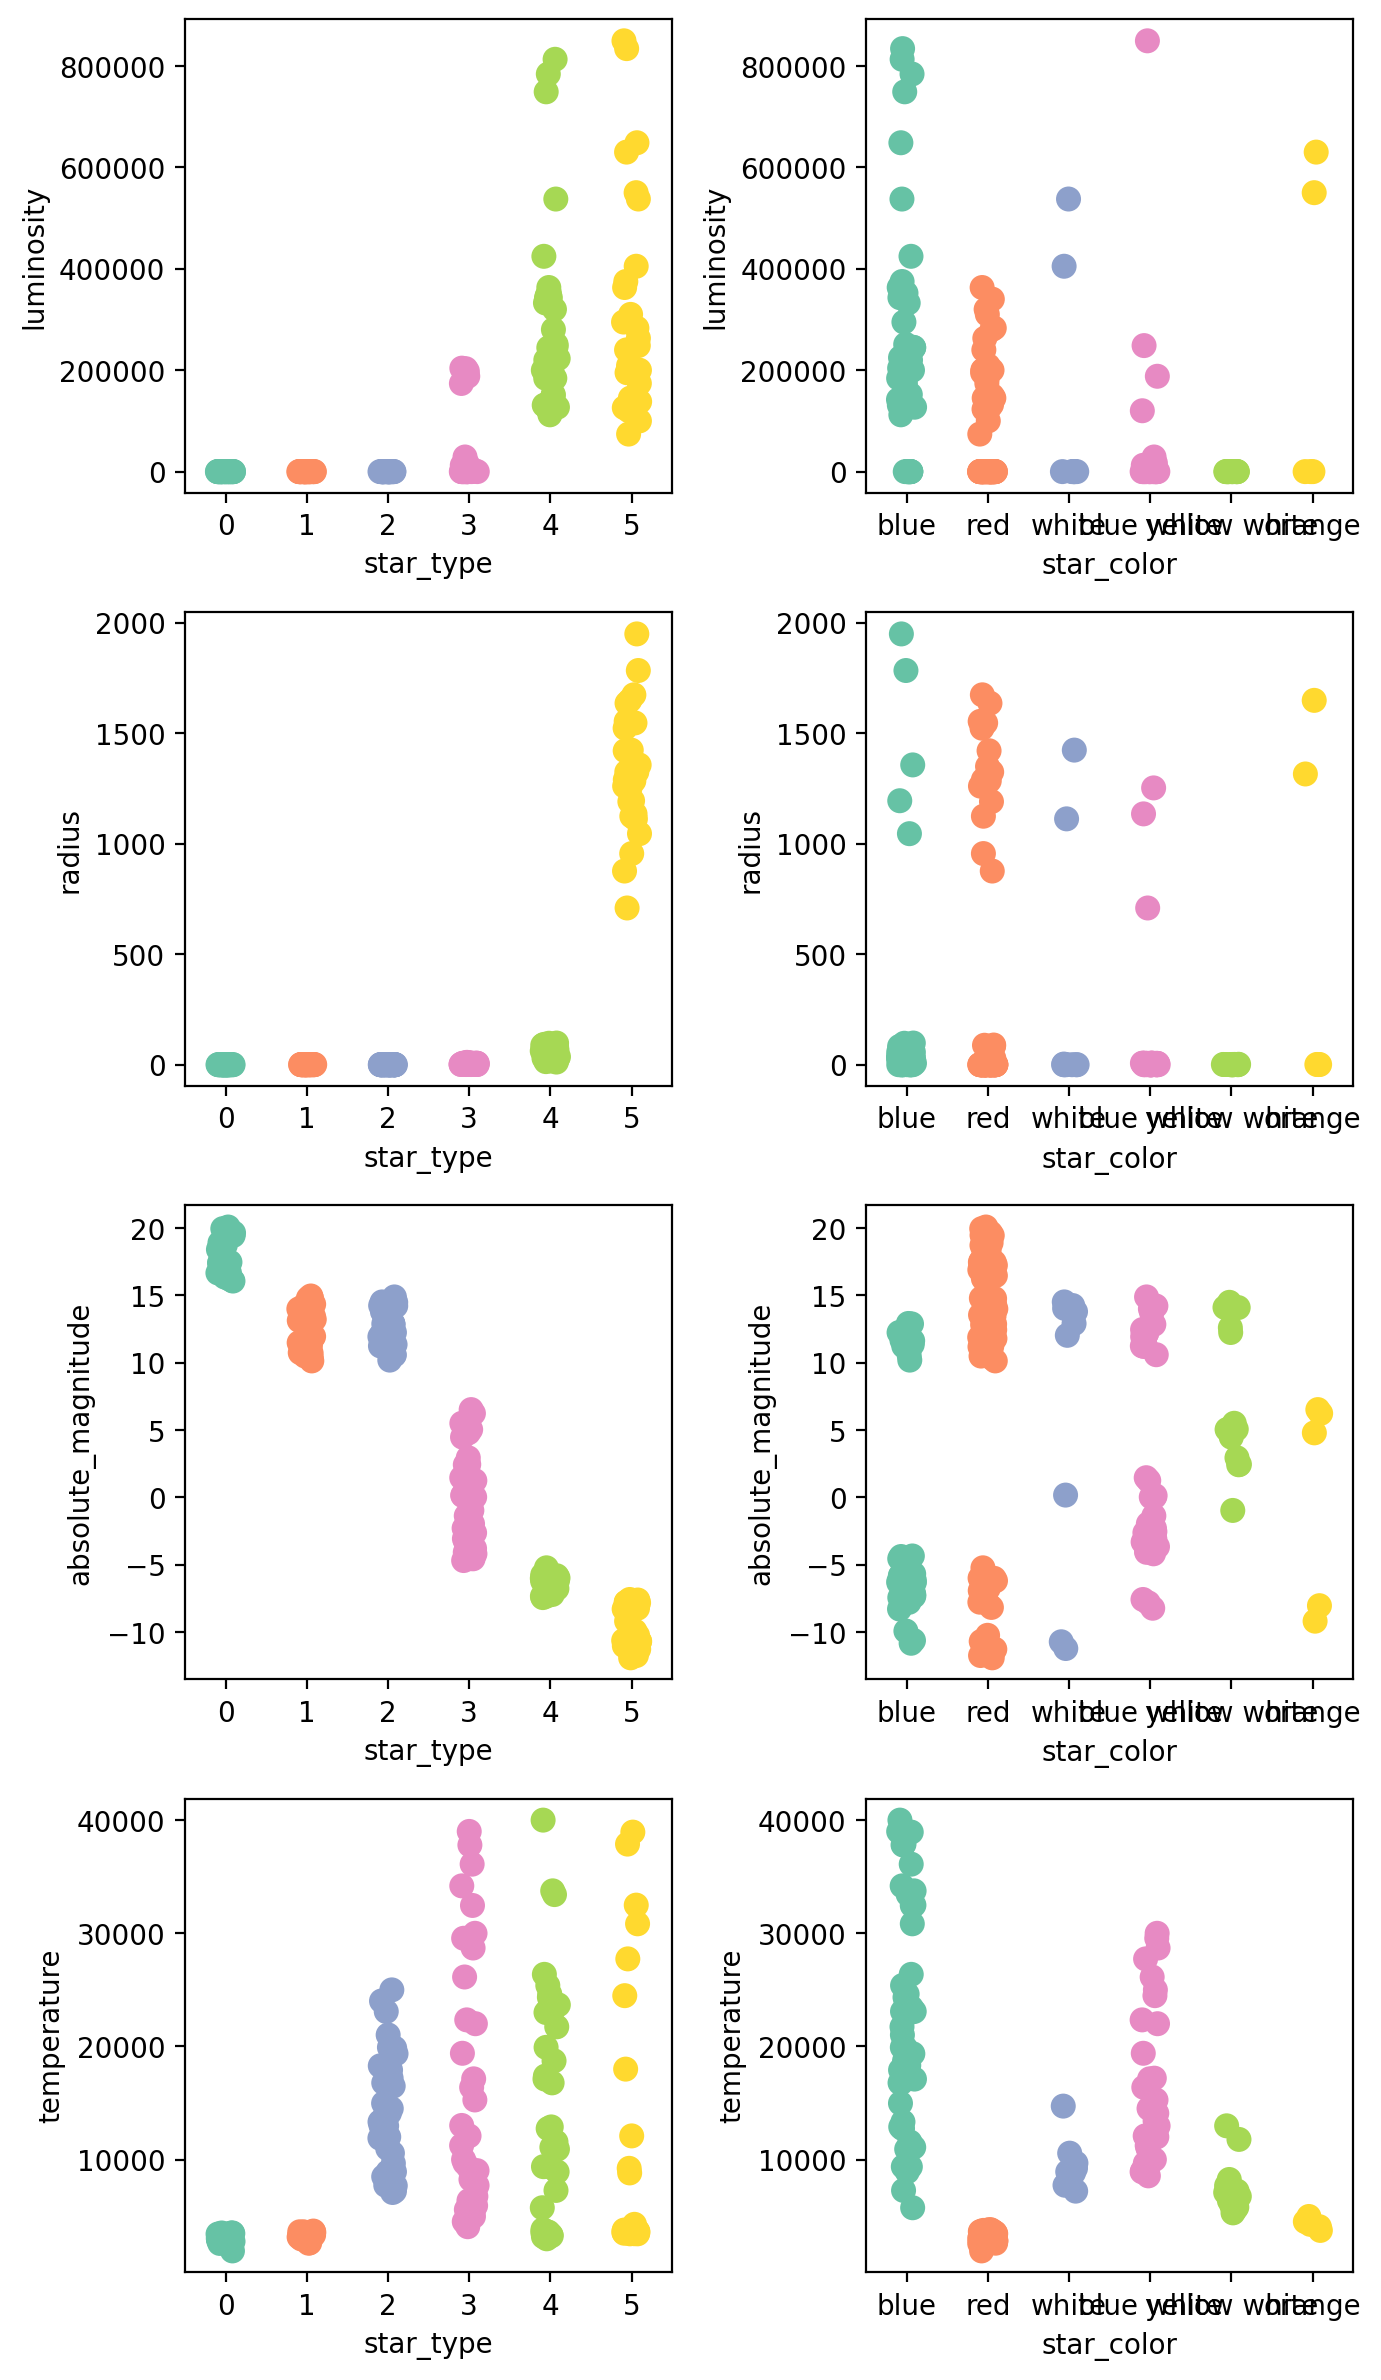

In [35]:
with sns.color_palette("Set2"):
    fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(7, 12))
    for j, category in enumerate(categorical_columns):
        for i, col in enumerate(numerical_columns+target_column):
            sns.stripplot(data=df,
                          x=category,
                          y=col,
                          ax=axes[i, j],
                          size=9)
plt.tight_layout()
plt.show()

Мы видим, что связи между признаками есть, но они в большинстве случаев носят нелинейный характер. Линейную связь вилим только между типом звезды и абсолютной звездной величиной. Еще видим степенную зависимость между абсолютной звездной величиной и температурой в середине диапазона значений $M_v$.

#### Анализ мультиколлинеарности

- https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/
- https://etav.github.io/python/vif_factor_python.html
- https://towardsdatascience.com/how-to-remove-multicollinearity-in-dataset-using-pca-4b4561c28d0b

Поскольку мы видим связи между признаками, выполним анализ мультиколлинеарности признаков.

Закодируем категориальные признаки и подготовим датасет для анализа.

In [36]:
ohe_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
encoded = pd.DataFrame(ohe_encoder.fit_transform(
    df[categorical_columns]),
                       index=df.index)

encoded.columns = ohe_encoder.get_feature_names(categorical_columns)

encoded = (
    df
    # удалим целевой признак и категориальные признаки
    .drop(columns=target_column + categorical_columns)
    # присоединим закодированные признаки
    .join(encoded)
    # удалим первую закодированную категорию каждого признака
    .drop(columns=[encoded.columns[0], encoded.columns[len(ohe_encoder.categories_[0])]
    ]))

Рассчитаем фактор инфляции дисперсии $\mathit{VIF} = \frac{1}{1 - R^2}$ для признаков датасета. Значения больше 5 говорят о высокой мультиколлинеарности рассматриваемого признака с остальными признаками датасета.

In [37]:
encoded.head().T

,168,71,21,81,9
luminosity,342900.00,0.022,0.00049,0.00014,0.00018
radius,30.00,0.380,0.01234,0.00920,0.13000
absolute_magnitude,-6.09,10.120,14.02000,12.02000,16.05000
star_type_1,0.00,1.000,0.00000,0.00000,0.00000
star_type_2,0.00,0.000,1.00000,1.00000,0.00000
star_type_3,0.00,0.000,0.00000,0.00000,0.00000
star_type_4,1.00,0.000,0.00000,0.00000,0.00000
star_type_5,0.00,0.000,0.00000,0.00000,0.00000
star_color_blue white,0.00,0.000,0.00000,0.00000,0.00000
star_color_orange,0.00,0.000,0.00000,0.00000,0.00000


Расчитаем фактора инфляции дисперсии.

In [38]:
vif = calc_vif(exogs=encoded.columns, data=encoded)
vif[vif.VIF>5].VIF

radius                23.517280
absolute_magnitude    51.080592
star_type_2            7.702433
star_type_3           31.141006
star_type_4           40.984543
star_type_5           63.982144
Name: VIF, dtype: float64

У пяти признаков значение фактора инфляции дисперсии больше 10, еще у одного больше 5. Такой результат — следствие их мультиколлинеарности относительно остальных признаков нашего набора.

In [39]:
multicollinear_features = vif[vif.VIF>5].VIF.index.to_list()
multicollinear_features

['radius',
 'absolute_magnitude',
 'star_type_2',
 'star_type_3',
 'star_type_4',
 'star_type_5']

### Выводы

Сруктура и содержание данных соответствуют описанию в задаче, пропусков и дубликатов в данных нет.

В данных три численных непрерывных признака и два категориальных.

Значения численных признаков имеют большой диапазон, возможно надо перевести эти признаки в логарифмическую шкалу. 

Значения цвета в датасете представлены 18 значениями, среди которых есть скрытые дубли из-за разного регистра и использования либо дефиса, либо пробела. Также используются разные варианты описания цвета. Мы разработали функции сокращения количества значений за счет удаления неявных дубликатов `normalize_color_values` и объединили редкие значения в более крупные группы, ориентируясь на значения температуры для цветов. Функция для сокращения значений, использующая словарь соответствий, —`color_value_reduction_func`.

Анализируя взаимосвязи признаков, мы выявили шесть признаков со значением фактора инфляции дисперсии больше 5. 

## Подготовка данных

### Сокращение количества значений признака цвет звезды

In [40]:
X_train.star_color = X_train.star_color.apply(normalize_color_values)
X_train.star_color = X_train.star_color.apply(color_value_reduction_func)

/Volumes/T7/working/yp14-torch-nn-refression/venv/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
X_test.star_color = X_test.star_color.apply(normalize_color_values)
X_test.star_color = X_test.star_color.apply(color_value_reduction_func)

In [42]:
X_train.star_color.nunique()

6

Значения унифицированы.

### Кодирование категориальных признаков

In [43]:
ohe_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
ohe_encoder.fit(X_train[categorical_columns])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [44]:
encoded_columns = ohe_encoder.get_feature_names(categorical_columns)

X_train = (
    X_train
    .drop(columns=categorical_columns)
    .join(pd.DataFrame(ohe_encoder.transform(X_train[categorical_columns]),
                       index=X_train.index, 
                       columns=encoded_columns))
    .drop(columns=[encoded_columns[0], encoded_columns[len(ohe_encoder.categories_[0])]
    ]))

X_test = (
    X_test
    .drop(columns=categorical_columns)
    .join(pd.DataFrame(ohe_encoder.transform(X_test[categorical_columns]),
                       index=X_test.index, 
                       columns=encoded_columns))
    .drop(columns=[encoded_columns[0], encoded_columns[len(ohe_encoder.categories_[0])]
    ]))

X_train.shape, X_test.shape

((204, 13), (36, 13))

In [45]:
X_train.head().T

,168,71,21,81,9
luminosity,342900.00,0.022,0.00049,0.00014,0.00018
radius,30.00,0.380,0.01234,0.00920,0.13000
absolute_magnitude,-6.09,10.120,14.02000,12.02000,16.05000
star_type_1,0.00,1.000,0.00000,0.00000,0.00000
star_type_2,0.00,0.000,1.00000,1.00000,0.00000
star_type_3,0.00,0.000,0.00000,0.00000,0.00000
star_type_4,1.00,0.000,0.00000,0.00000,0.00000
star_type_5,0.00,0.000,0.00000,0.00000,0.00000
star_color_blue white,0.00,0.000,0.00000,0.00000,0.00000
star_color_orange,0.00,0.000,0.00000,0.00000,0.00000


Признаки закодированы.

### Масштабирование числовых признаков

Переведем значения относительной светимости и радиуса в логарифмическую шкалу.

In [46]:
X_train[["luminosity", "radius"]] = np.log10(X_train[["luminosity", "radius"]])

In [47]:
X_test[["luminosity", "radius"]] = np.log10(X_test[["luminosity", "radius"]])

In [48]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_columns])

StandardScaler()

In [49]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
X_train[numerical_columns].describe()

,luminosity,radius,absolute_magnitude
count,2.040000e+02,2.040000e+02,2.040000e+02
mean,-3.047671e-17,4.353816e-18,-6.095342e-17
std,1.002460e+00,1.002460e+00,1.002460e+00
min,-1.189075e+00,-1.370758e+00,-1.601370e+00
25%,-9.326980e-01,-7.285069e-01,-1.040117e+00
50%,-5.720708e-01,-2.664833e-01,5.492566e-01
75%,1.192105e+00,7.964118e-01,8.658793e-01
max,1.357453e+00,1.838811e+00,1.478659e+00


Масштабирование сделано.

In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 168 to 90
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   luminosity               204 non-null    float64
 1   radius                   204 non-null    float64
 2   absolute_magnitude       204 non-null    float64
 3   star_type_1              204 non-null    float64
 4   star_type_2              204 non-null    float64
 5   star_type_3              204 non-null    float64
 6   star_type_4              204 non-null    float64
 7   star_type_5              204 non-null    float64
 8   star_color_blue white    204 non-null    float64
 9   star_color_orange        204 non-null    float64
 10  star_color_red           204 non-null    float64
 11  star_color_white         204 non-null    float64
 12  star_color_yellow white  204 non-null    float64
dtypes: float64(13)
memory usage: 30.4 KB


In [51]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36 entries, 122 to 170
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   luminosity               36 non-null     float64
 1   radius                   36 non-null     float64
 2   absolute_magnitude       36 non-null     float64
 3   star_type_1              36 non-null     float64
 4   star_type_2              36 non-null     float64
 5   star_type_3              36 non-null     float64
 6   star_type_4              36 non-null     float64
 7   star_type_5              36 non-null     float64
 8   star_color_blue white    36 non-null     float64
 9   star_color_orange        36 non-null     float64
 10  star_color_red           36 non-null     float64
 11  star_color_white         36 non-null     float64
 12  star_color_yellow white  36 non-null     float64
dtypes: float64(13)
memory usage: 5.0 KB


In [52]:
X_train.shape, y_train.shape

((204, 13), (204,))

In [53]:
X_test.shape, y_test.shape

((36, 13), (36,))

### Вывод

Мы подготовили данные в соответсвии с выялвенными на этапе анализа выводами: сократили количество значений признака цвет звезды, закодировали категориальные признаки методом OHE, перевели значения `luminosity` и `radius` в логарифмическую шаклу и выполнили масштабирование численных признаков, приведя среднее значение к нулю и стандартное отклонение к 1.

## Построение baseline модели

Выделим валидационную выборку

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    shuffle=True,
    random_state=RANDOM_STATE)

In [55]:
X_train.shape, y_train.shape

((163, 13), (163,))

In [56]:
X_test.shape, y_test.shape

((36, 13), (36,))

In [57]:
X_train_t = torch.FloatTensor(X_train.values)
X_valid_t = torch.FloatTensor(X_valid.values)
y_train_t = torch.FloatTensor(y_train.values)
y_valid_t = torch.FloatTensor(y_valid.values)

In [58]:
X_train_t.size()

torch.Size([163, 13])

### Dummy модель

In [59]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
pred = dummy_regr.predict(X_valid)
print(f"Dummy MSE {mean_squared_error(pred, y_valid):,.0f}")

Dummy MSE 96,475,432


In [60]:
n_in_neurons = X_train_t.size()[1]
n_hidden_neurons_1 = n_in_neurons
n_hidden_neurons_2 = n_hidden_neurons_1
n_out_neurons = 1 

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
)
net

Sequential(
  (0): Linear(in_features=13, out_features=13, bias=True)
  (1): ReLU()
  (2): Linear(in_features=13, out_features=13, bias=True)
  (3): ReLU()
  (4): Linear(in_features=13, out_features=1, bias=True)
)

In [61]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)
loss = nn.MSELoss()

In [62]:
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(X_train_t)

    loss_value = loss(preds, y_train_t)

    loss_value.backward()

    optimizer.step()

    if epoch % 500 == 0 or epoch == num_epochs - 1:
        net.eval()
        preds_valid = net.forward(X_valid_t)
        mse = loss(preds_valid, y_valid_t)
        print(f"Loss train {loss_value:,.0f}\tvalid {mse:,.0f}")
        net.train()

Loss train 203,017,328	valid 196,435,296


/Volumes/T7/working/yp14-torch-nn-refression/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([163])) that is different to the input size (torch.Size([163, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Volumes/T7/working/yp14-torch-nn-refression/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([41])) that is different to the input size (torch.Size([41, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss train 90,132,912	valid 96,603,264
Loss train 90,115,792	valid 96,565,064
Loss train 90,103,928	valid 96,547,344
Loss train 90,096,072	valid 96,529,832
Loss train 90,089,392	valid 96,509,032
Loss train 90,086,456	valid 96,497,112
Loss train 90,084,968	valid 96,489,448
Loss train 90,084,464	valid 96,485,280
Loss train 90,084,360	valid 96,482,712
Loss train 90,084,264	valid 96,481,216


## Улучшение модели

## Выводы